In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import math
import string
import sdeint
import random
import statistics
import scipy.signal
import scipy.stats as st

from scipy.stats import lognorm, expon, rv_continuous, kurtosis, ttest_ind
from scipy import stats,optimize
from scipy.integrate import odeint
from scipy.optimize import curve_fit,minimize
from scipy.special import gamma, digamma

from joblib import Parallel, delayed 
from matplotlib import gridspec
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import accumulate
from collections import Counter
from datetime import datetime,timedelta
from pandas.plotting import register_matplotlib_converters
from PyEMD import EMD
register_matplotlib_converters()

In [2]:
#Read data
TBB_data = pd.read_csv('Dataframes\TBB_data.csv')
TKB_data = pd.read_csv('Dataframes\TKB_data.csv')
TChP_data = pd.read_csv('Dataframes\TChP_data.csv')
TH_data = pd.read_csv('Dataframes\TH_data.csv')
TPur_data = pd.read_csv('Dataframes\TPur_data.csv')
TPut_data = pd.read_csv('Dataframes\TPut_data.csv')
TCaP_data = pd.read_csv('Dataframes\TCaP_data.csv')
TBGP_data = pd.read_csv('Dataframes\TBGP_data.csv')
TEB_data = pd.read_csv('Dataframes\TEB_data.csv')


C:\Users\禾森\AppData\Local\Temp\ipykernel_21908\1141283412.py:2: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  TBB_data = pd.read_csv('Dataframes_new_new\TBB_data.csv')
C:\Users\禾森\AppData\Local\Temp\ipykernel_21908\1141283412.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  TKB_data = pd.read_csv('Dataframes_new_new\TKB_data.csv')
C:\Users\禾森\AppData\Local\Temp\ipykernel_21908\1141283412.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  TChP_data = pd.read_csv('Dataframes_new_new\TChP_data.csv')
C:\Users\禾森\AppData\Local\Temp\ipykernel_21908\1141283412.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  TH_data = pd.read_csv('Dataframes_new_new\TH_data.csv')


In [3]:

#de-trending via seasonal decompostion with a given filtering frequency
def seasonal_detrend(stationName, quantity, frequency):
    hour=4
    day=24*hour
    #detrending
    stationData=np.array(eval(str(stationName)+'_data')[quantity].dropna())
    #new line
    stationData=stationData[stationData>0]
    result_mul = seasonal_decompose(stationData, model='multiplicative', extrapolate_trend='freq', period=frequency)
    #detrended = stationData  / (result_mul.trend * result_mul.resid)
    detrended = stationData  / result_mul.trend
    return detrended, result_mul.trend

#de-trending via EMD mode decomposition, omitting the last few modes as noise
def emd_detrending(stationName,quantity,numberOfOmmitedModes):
    #retrieve the station data to be analysed
    stationData=np.array(eval(str(stationName)+'_data')[quantity].dropna())
    stationData=stationData[stationData>0]
    # Log transformation to turn multiplicative relationships into additive
    log_stationData = np.log(stationData)
    #perform EMD analysis
    emd = EMD()
    IMFs = emd(log_stationData)
    numberOfModes=len(IMFs)
    summedModes=np.zeros(len(IMFs[0]))
    for modeIndex in range(1,numberOfModes-numberOfOmmitedModes):
        #compute the new sum of modes that approximates the trend
        summedModes += IMFs[numberOfModes-modeIndex]
    # Subtract the trend from the log-transformed data
    detrended_log = log_stationData - summedModes
    trend = np.exp(summedModes)
    # Exponentiate to revert the log transformation
    detrended = np.exp(detrended_log)
    return detrended,trend

#function to select which de-trending method we apply
def detrending(stationName, quantity, method, detrendingParameter):
    if method=='Seasonal':
        return seasonal_detrend(stationName, quantity, detrendingParameter)
    if method=='EMD':
        return emd_detrending(stationName, quantity, detrendingParameter)

In [24]:
def quantityLabels(quantity):
    if quantity=='DOO-MGL':
        xlabel='Oxygen concentration fluctuations [mg/L]'
        exportName='Oxygen'
    return (xlabel,exportName)

#define custom pdf for the q-Gaussian distribution
def q_Gauss_pdf(x,q,l,mu):
    constant=np.sqrt(np.pi)*gamma((3-q)/(2*(q-1)))/(np.sqrt(q-1)*gamma(1/(q-1)))
    pdf=np.sqrt(l)/constant*(1+(1-q)*(-l*(x-mu)**2))**(1/(1-q))
    return pdf

class q_Gauss_custom(st.rv_continuous):
    def _pdf(self, x, q, l,mu):
        "Custom q-Gauss distribution"
        pdf =q_Gauss_pdf(x,q,l,mu)
        return pdf
    def _stats(self, q, l):
        return [self.q,self.l,0,0]
    #fitstart provides a starting point for any MLE fit
    def _fitstart(self,data):
        q_guess= 1.5
        mu_guess= np.mean(data)
        l_guess=10000
        return (q_guess,l_guess)
    def _argcheck(self, q,l,mu):
        #define an arbitrary number of conditions on the arguments, such as psotivitiy or a certain range
        largeQ = q > 1
        positiveScale=l>0
        all_bool = largeQ&positiveScale
        return all_bool

# Create an instance of the custom distribution
qGauss_custom_inst = q_Gauss_custom(name='qGauss_custom', a=0)


def import_detrending(stationName,quantity,method):
    detrended=np.loadtxt("DetrendedData/"+str(stationName)+str(quantity)+str(method)+".csv", delimiter=",")
    return detrended

def plot_fluctuation_histo_axs(quantity, method,stationName, axis,labelNo,q_initial,l_initial):
    (xlabel,exportName)=quantityLabels(quantity)
    #plt.hist(detrended, density=True,log=True)
    detrended=import_detrending(stationName,quantity,method)
    plot=sns.distplot(detrended,ax=axis)
    #extract distplot range
    (xvalues_hist,yvalues_hist)=plot.get_lines()[0].get_data()
    qGaussParameters = qGauss_custom_inst.fit(detrended,q_initial,l_initial,np.mean(detrended))
    print("Parameters:", qGaussParameters)
    qGaussValues=q_Gauss_pdf(xvalues_hist,qGaussParameters[0],qGaussParameters[1],np.mean(detrended))
    axis.plot(xvalues_hist,qGaussValues,color='deeppink')
    plt.legend([stationName+' Data','q-Gaussian'],loc=4)
    axis.set_yscale('log')
    axis.set_ylim(0.1*min(qGaussValues),10*max(qGaussValues))
    #axis.set_xlabel(xlabel)
    axis.set_ylabel('PDF')
    axis.set_title(method+'_multiplicative, q='+str(round(qGaussParameters[0],3))+', \u03B2='+str(round(qGaussParameters[1],3)), fontsize=18)
    axis.text(0.05, 0.9, string.ascii_lowercase[labelNo], transform=axis.transAxes,size=20, weight='bold')
    #compute log-likelihood        
    q_likelihood = 0
    for item in detrended:          
        #choose q-value
        q_likelihood = np.log(q_Gauss_pdf(item,qGaussParameters[0],qGaussParameters[1],np.mean(detrended)))
        q_likelihood += q_likelihood
    print("q_likelihood: "+str(round(q_likelihood,3)))

## TBGP

In [ ]:
plt.rc('font', size=14)

In [5]:
#DOO
hour=4
stationName = 'TBGP'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=3
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=4 
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [6]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")

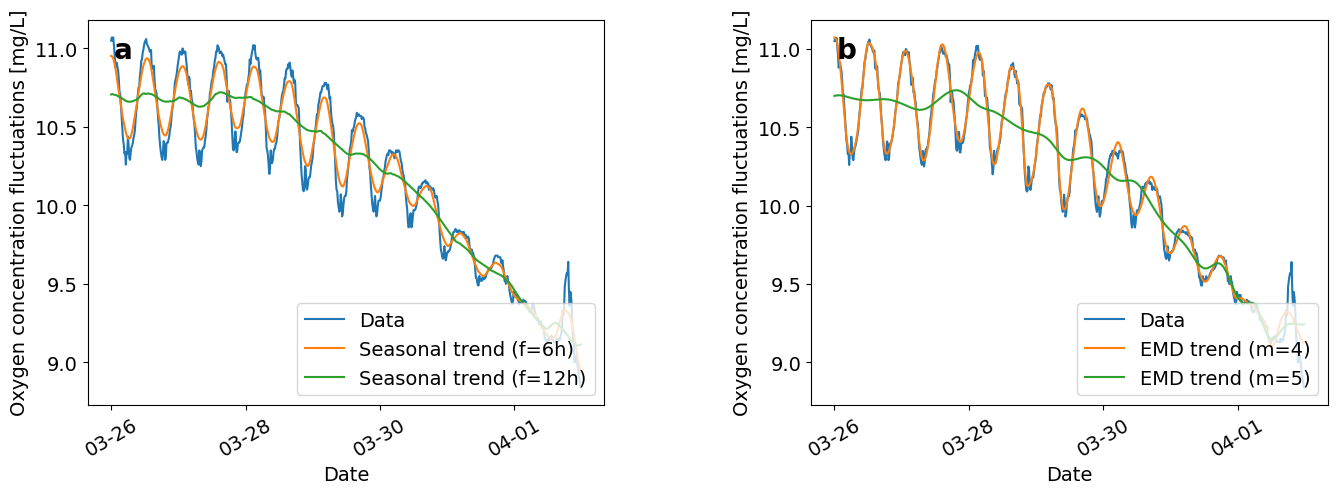

In [9]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=4000
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['Data','Seasonal trend (f=6h)','Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['Data','EMD trend (m=4)','EMD trend (m=5)'], loc=4)
ax1.text(0.05, 0.9, string.ascii_lowercase[0], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.05, 0.9, string.ascii_lowercase[1], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30) 
    axs.set_ylabel(xlabel)
    axs.set_xlabel('Date')
fig.subplots_adjust(wspace =0.4)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show() 

In [567]:
#read the data
stationName = 'TBGP'
fluctuations_Seasonal_DOO = np.loadtxt('DetrendedData/' + stationName + 'DOO-MGLSeasonal.csv', delimiter=',')
fluctuations_EMD_DOO = np.loadtxt('DetrendedData/' + stationName + 'DOO-MGLEMD.csv', delimiter=',')

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.6314849357055257, 6083.572892634318, 1.3252909250262968, 1.526185643568377, 1.0683847356413803e-27)
q_likelihood-2.336


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2042: RuntimeWarning: invalid value encountered in log
  return log(p)


Parameters: (1.5892948739553643, 8115.015906465252, 1.2746939056467337, 0.22320572350421825, 0.6093739095072074)
q_likelihood5.535


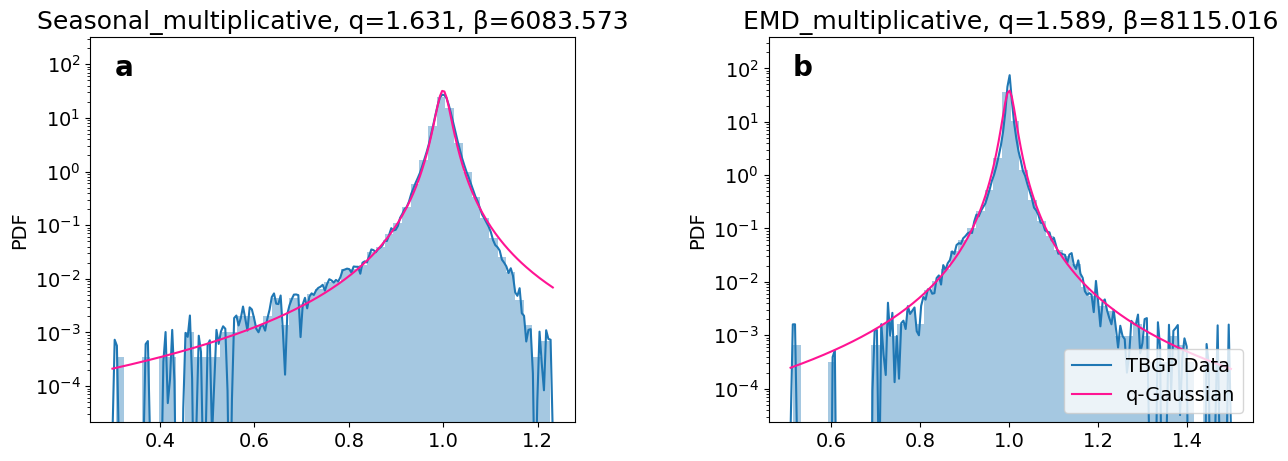

In [21]:
#set up subplots EMD 4
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
stationName='TBGP'
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,0,1.4,5000)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,1,1.1,5000)
f.subplots_adjust(wspace =0.4,hspace=0.4)
#plt.savefig('Figs/'+stationName+'_Fitting.pdf', bbox_inches='tight')
plt.show()

## TBB

In [93]:
hour=4
stationName = 'TBB'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=250
length=hour*24*7

In [484]:
#DOO
hour=4
stationName = 'TBB'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=4
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=5 
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [486]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")

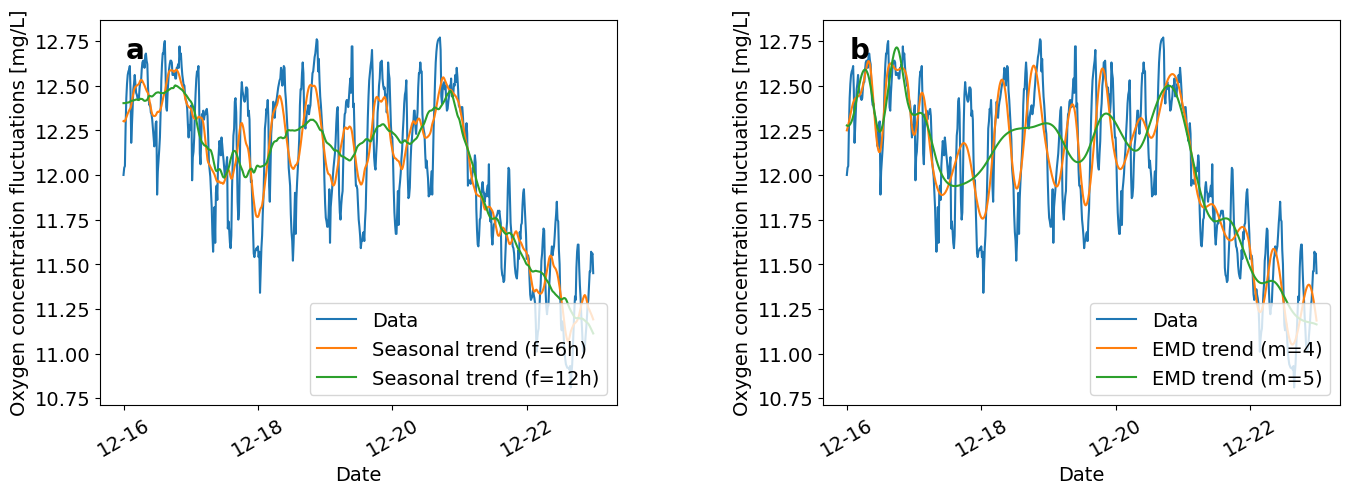

In [488]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=1500
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['Data','Seasonal trend (f=6h)','Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['Data','EMD trend (m=4)','EMD trend (m=5)'], loc=4)
ax1.text(0.05, 0.9, string.ascii_lowercase[0], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.05, 0.9, string.ascii_lowercase[1], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30) 
    axs.set_ylabel(xlabel)
    axs.set_xlabel('Date')
fig.subplots_adjust(wspace =0.4)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show()

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2042: RuntimeWarning: invalid value encountered in log
  return log(p)


Parameters: (1.5660466158579749, 2035.2961089378186, 1.423672476861498, -0.3975080137715815, 0.9812668884353433)
q_likelihood5.311


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2042: RuntimeWarning: invalid value encountered in log
  return log(p)
C:\Users\禾森\AppData\Local\Temp\ipykernel_21908\3681675826.py:9: RuntimeWarning: invalid value encountered in double_scalars
  constant=np.sqrt(np.pi)*gamma((3-q)/(2*(q-1)))/(np.sqrt(q-1)*gamma(1/(q-1)))


Parameters: (1.5625251299504495, 1047.0960381619589, 0.2513564238718645, -2.7135491907713973, 14.581121091239126)
q_likelihood4.722


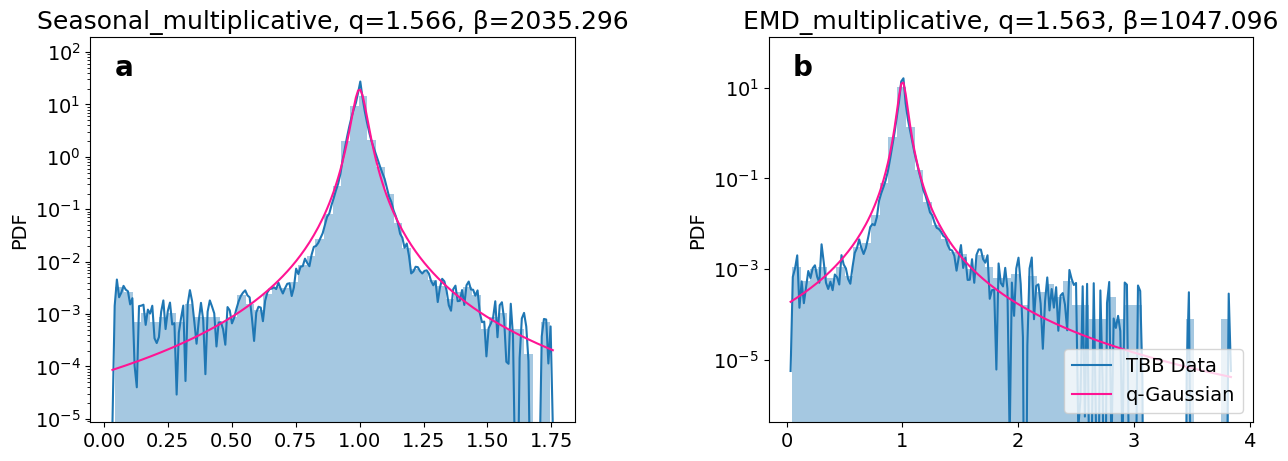

In [22]:
#set up subplots EMD 4
stationName = 'TBB'
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,0,2,600)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,1,1.2,2000) #1.27 3100
f.subplots_adjust(wspace =0.4,hspace=0.4)
#plt.savefig('Figs/'+stationName+'_Fitting.pdf', bbox_inches='tight')
plt.show()

## TCaP

In [569]:
#DOO
hour=4
stationName = 'TCaP'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=3
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=4 
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [570]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")

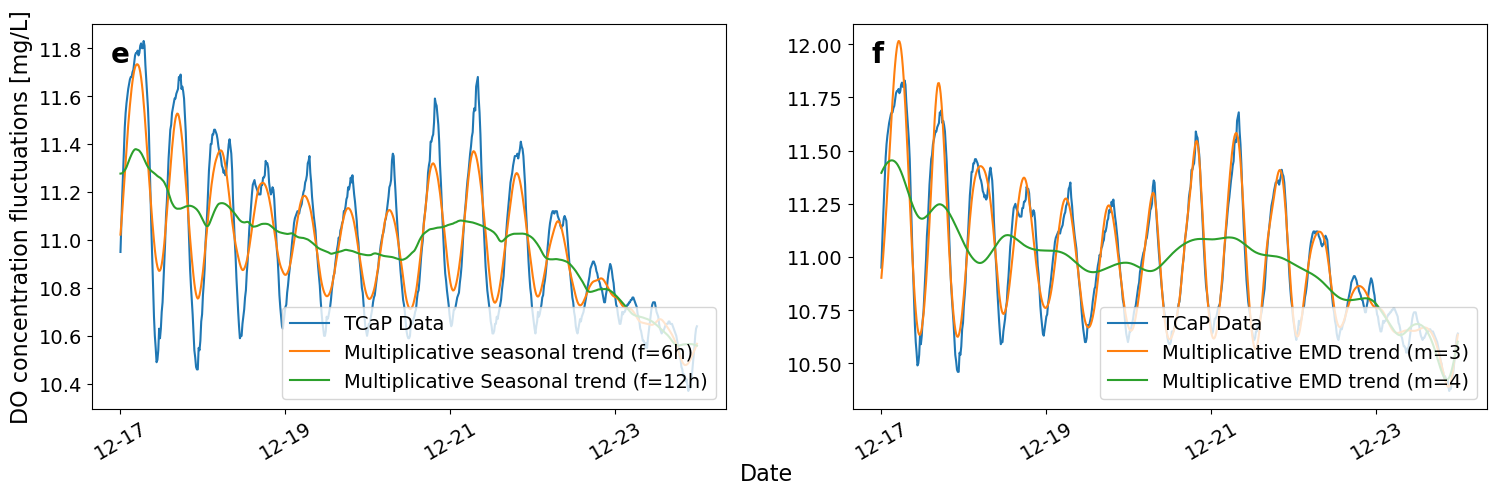

In [7]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=1600
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['TCaP Data','Multiplicative seasonal trend (f=6h)','Multiplicative Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['TCaP Data','Multiplicative EMD trend (m=3)','Multiplicative EMD trend (m=4)'], loc=4)
ax1.text(0.03, 0.9, string.ascii_lowercase[4], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.03, 0.9, string.ascii_lowercase[5], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30)     
    
ax1.set_ylabel('DO concentration fluctuations [mg/L]', fontsize=16)
fig.text(0.5, -0.02, 'Date', ha='center', va='center', fontsize=16)
fig.subplots_adjust(wspace =0.2)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show()

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.6329384962237041, 4164.68523804701, 1.2632147088304382, 1.5397948149581642, 4.394659508948457e-25)
q_likelihood: 3.54


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2042: RuntimeWarning: invalid value encountered in log
  return log(p)


Parameters: (1.7615999436260426, 7789.01592287255, 1.7745256527715911, -0.13169892249816106, 0.6376857632139674)
q_likelihood: 7.018


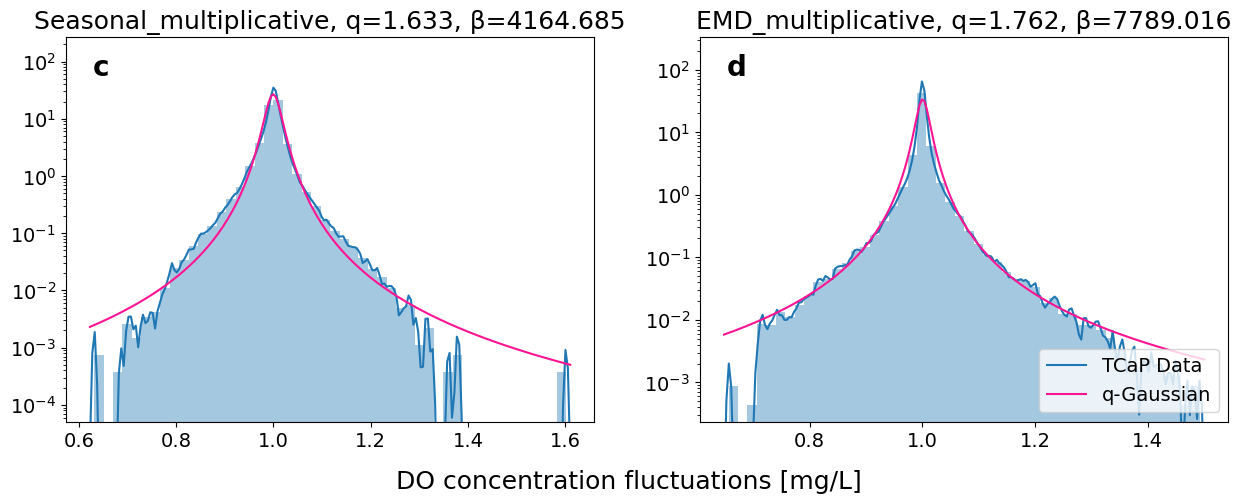

In [25]:
stationName = 'TCaP'
#set up subplots EMD 3
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,2,1.15,4200)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,3,1.2,5000)
(xlabel, _) = quantityLabels('DOO-MGL')  # Assuming both subplots use the same x-label
f.text(0.5, -0.01, 'DO concentration fluctuations [mg/L]', ha='center', va='center', fontsize=18)
#ax1.set_ylabel('PDF', fontsize=18)
ax1.set_ylabel('')
ax2.set_ylabel('')
f.subplots_adjust(wspace =0.2,hspace=0.2)
#plt.savefig('Figs/'+stationName+'_Fitting.pdf', bbox_inches='tight')
plt.show()

## TChP

In [599]:
#DOO
hour=4
stationName = 'TChP'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=4
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=5
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [600]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")

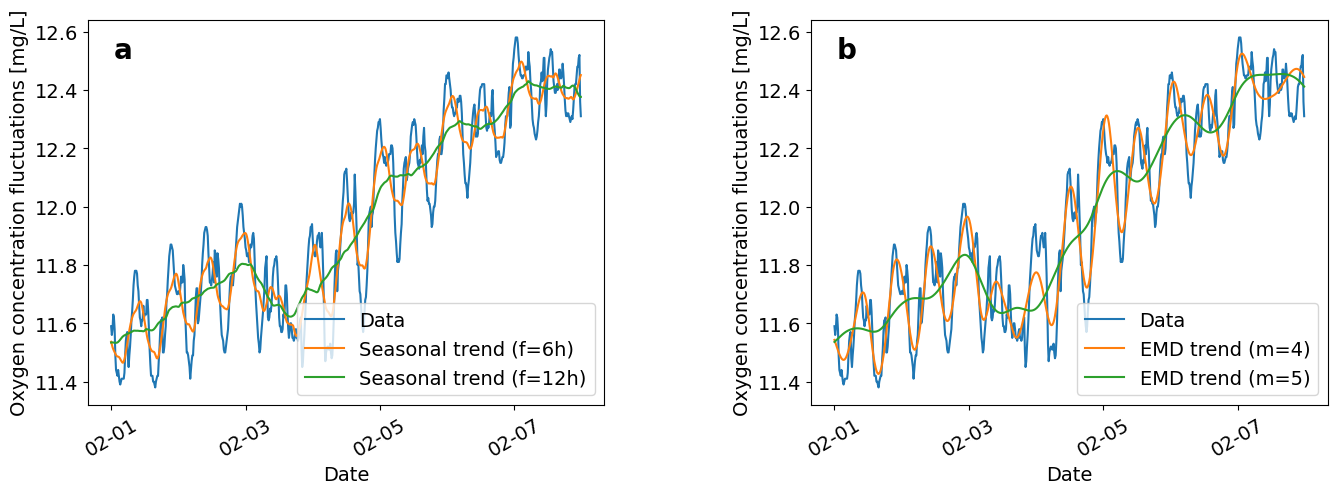

In [601]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=6000
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['Data','Seasonal trend (f=6h)','Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['Data','EMD trend (m=4)','EMD trend (m=5)'], loc=4)
ax1.text(0.05, 0.9, string.ascii_lowercase[0], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.05, 0.9, string.ascii_lowercase[1], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30) 
    axs.set_ylabel(xlabel)
    axs.set_xlabel('Date')
fig.subplots_adjust(wspace =0.4)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show()

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.5149502974408298, 3163.4579041698553, 1.3252408047588913, 1.526185643568377, 1.0683847356413803e-27)
q_likelihood: 4.582


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2042: RuntimeWarning: invalid value encountered in log
  return log(p)


Parameters: (1.7105592549204158, 3716.9093642799917, 1.0435237971890106, 0.018979671297716074, 0.9401363117989383)
q_likelihood: 5.657


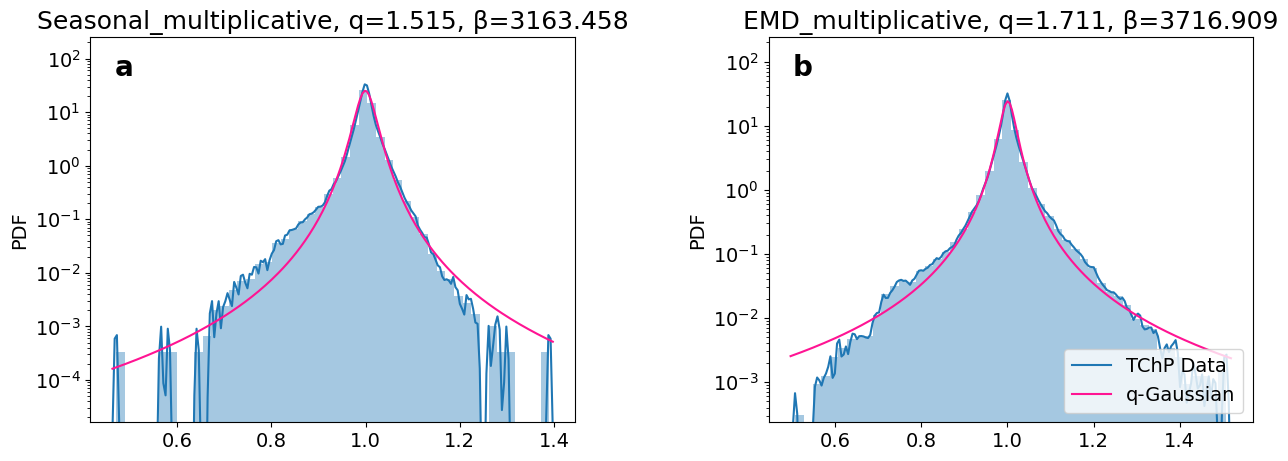

In [26]:
stationName = 'TChP'
#set up subplots EMD 4
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,0,1.3,2600)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,1,1.1,3300)
f.subplots_adjust(wspace =0.4,hspace=0.4)
plt.show()

## TEB

In [643]:
#DOO
hour=4
stationName = 'TEB'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=4
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=5 
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [644]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")

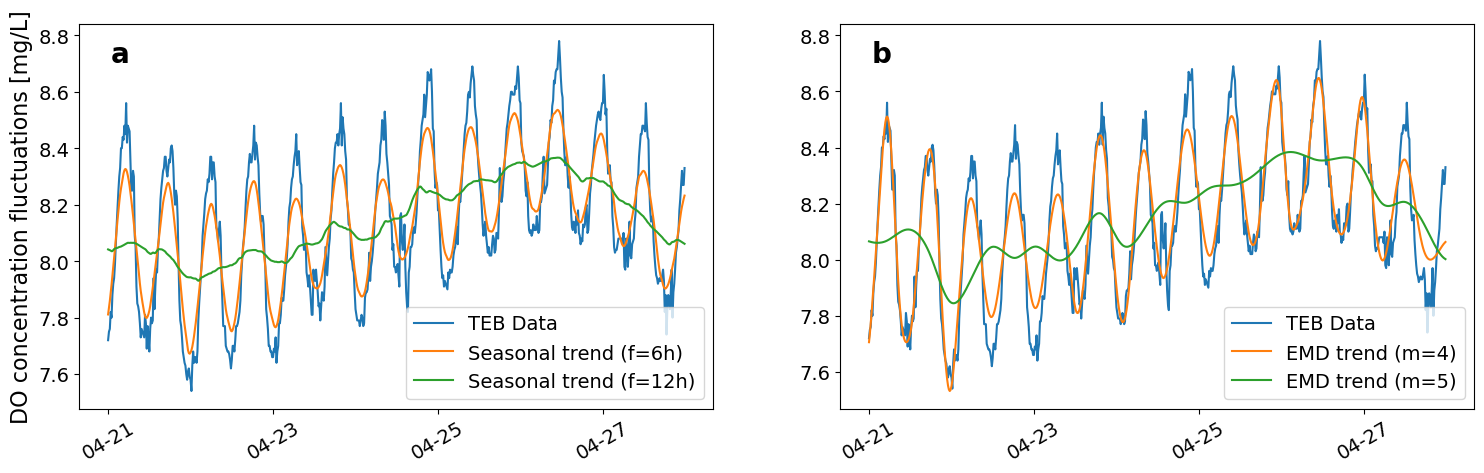

In [27]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=2+4*9+12*4
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['TEB Data','Seasonal trend (f=6h)','Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['TEB Data','EMD trend (m=4)','EMD trend (m=5)'], loc=4)
ax1.text(0.05, 0.9, string.ascii_lowercase[0], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.05, 0.9, string.ascii_lowercase[1], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30) 
    
ax1.set_ylabel('DO concentration fluctuations [mg/L]', fontsize=16)
fig.subplots_adjust(wspace =0.2)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show()

In [194]:
#read the data
stationName = 'TEB'
fluctuations_Seasonal_DOO = np.loadtxt('DetrendedData/' + stationName + 'DOO-MGLSeasonal.csv', delimiter=',')
fluctuations_EMD_DOO = np.loadtxt('DetrendedData/' + stationName + 'DOO-MGLEMD.csv', delimiter=',')

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.5799499058888697, 6577.082978741982, 1.273136717955596, -0.22264661758626267, 0.9597541880465721)
q_likelihood: -6.465


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.7478204346711812, 12050.60303871314, 1.4564237922948626, -0.4304695922761009, 0.9820959011846017)
q_likelihood: 3.501


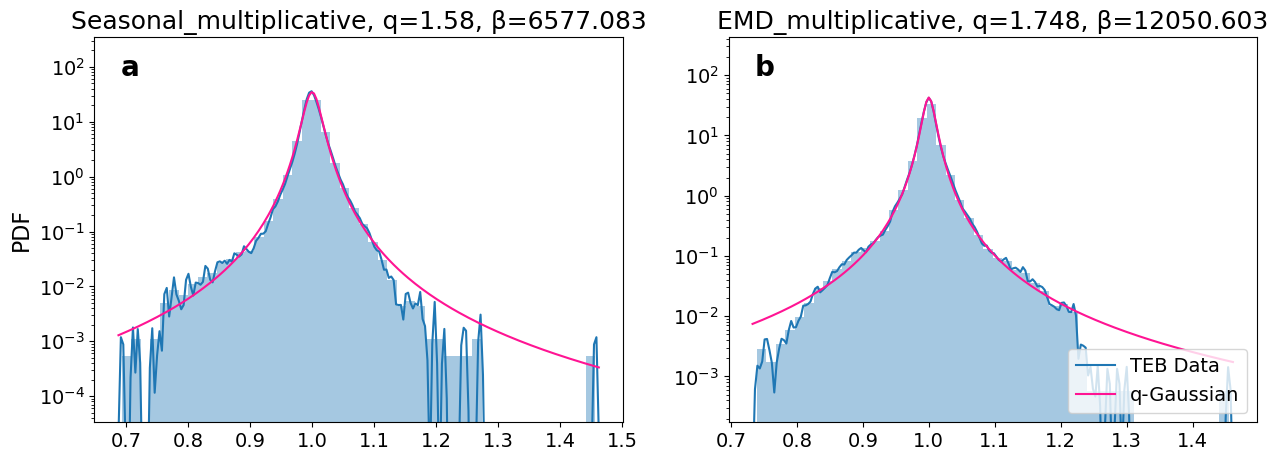

In [27]:
#set up subplots f = 6hours
stationName = 'TEB'
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,0,1.1,7000)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,1,1.1,7000)
ax1.set_ylabel('PDF', fontsize=16)
ax2.set_ylabel('')
f.subplots_adjust(wspace =0.2,hspace=0.2)
##plt.savefig('Figs/'+stationName+'_Fitting.pdf', bbox_inches='tight')
plt.show()

## TH

In [664]:
#DOO
hour=4
stationName = 'TH'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=4
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=5 
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [665]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")


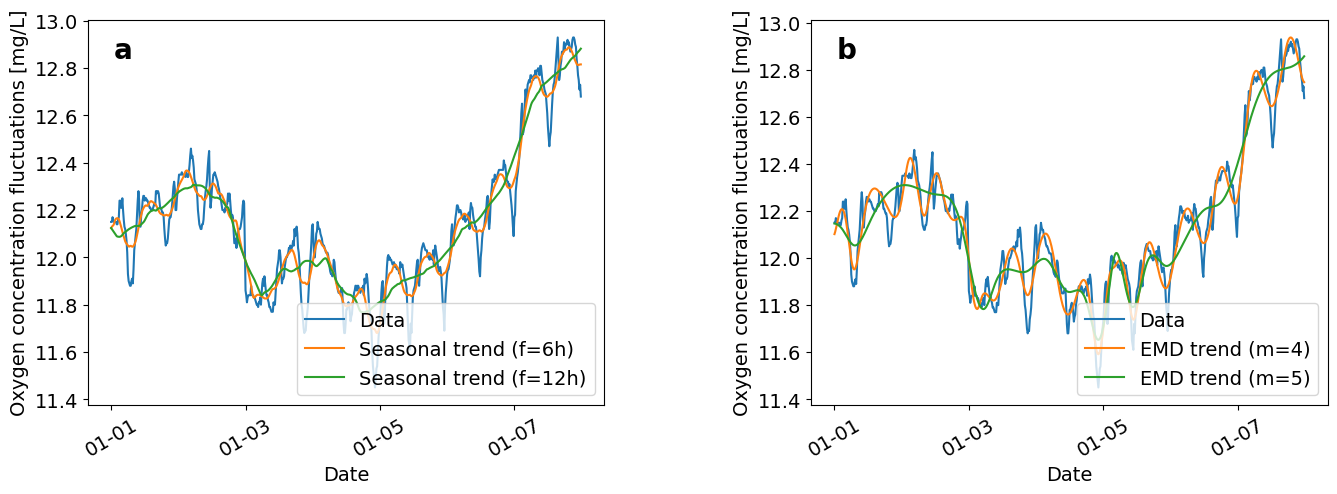

In [164]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=3000
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['Data','Seasonal trend (f=6h)','Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['Data','EMD trend (m=4)','EMD trend (m=5)'], loc=4)
ax1.text(0.05, 0.9, string.ascii_lowercase[0], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.05, 0.9, string.ascii_lowercase[1], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30) 
    axs.set_ylabel(xlabel)
    axs.set_xlabel('Date')
fig.subplots_adjust(wspace =0.4)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show()

In [24]:
#read the data
stationName = 'TH'
fluctuations_Seasonal_DOO = np.loadtxt('DetrendedData/' + stationName + 'DOO-MGLSeasonal.csv', delimiter=',')
fluctuations_EMD_DOO = np.loadtxt('DetrendedData/' + stationName + 'DOO-MGLEMD.csv', delimiter=',')

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2042: RuntimeWarning: invalid value encountered in log
  return log(p)


Parameters: (1.8053675346110136, 9602.296694846624, 1.408712105169485, -0.47512006148824115, 1.0470934838360275)
q_likelihood: 3.347


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2042: RuntimeWarning: invalid value encountered in log
  return log(p)


Parameters: (1.8537178626640367, 3835.8228074343824, 1.4780771469645817, 0.034808675418511445, 0.6530757094414688)
q_likelihood: 5.853


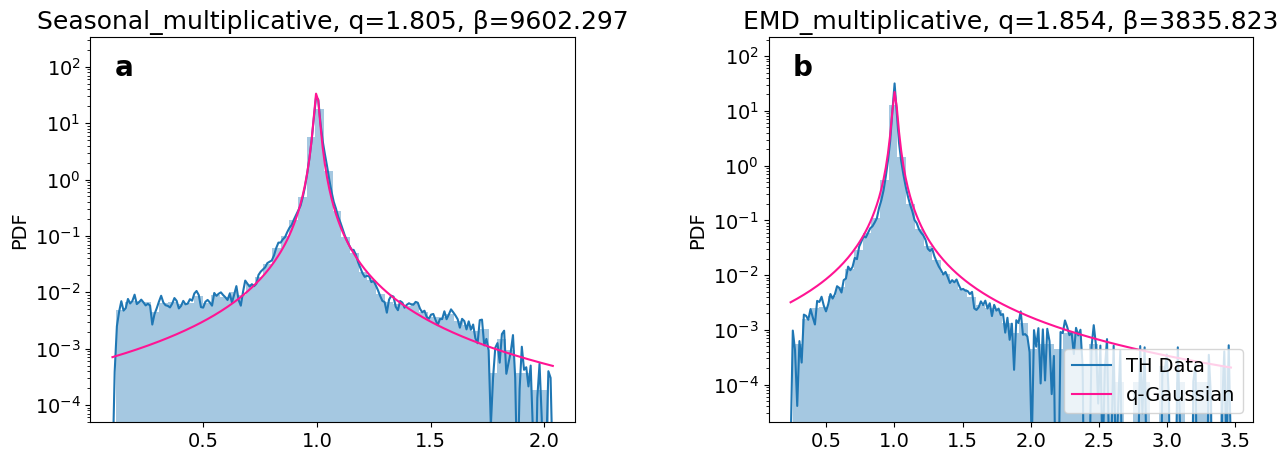

In [28]:
stationName = 'TH'
#set up subplots EMD 4
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,0,2,4000)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,1,2,5000)
f.subplots_adjust(wspace =0.4,hspace=0.4)
#plt.savefig('Figs/'+stationName+'_Fitting.pdf', bbox_inches='tight')
plt.show()

## TKB

In [696]:
#DOO
hour=4
stationName = 'TKB'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=3
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=4 
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [697]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")


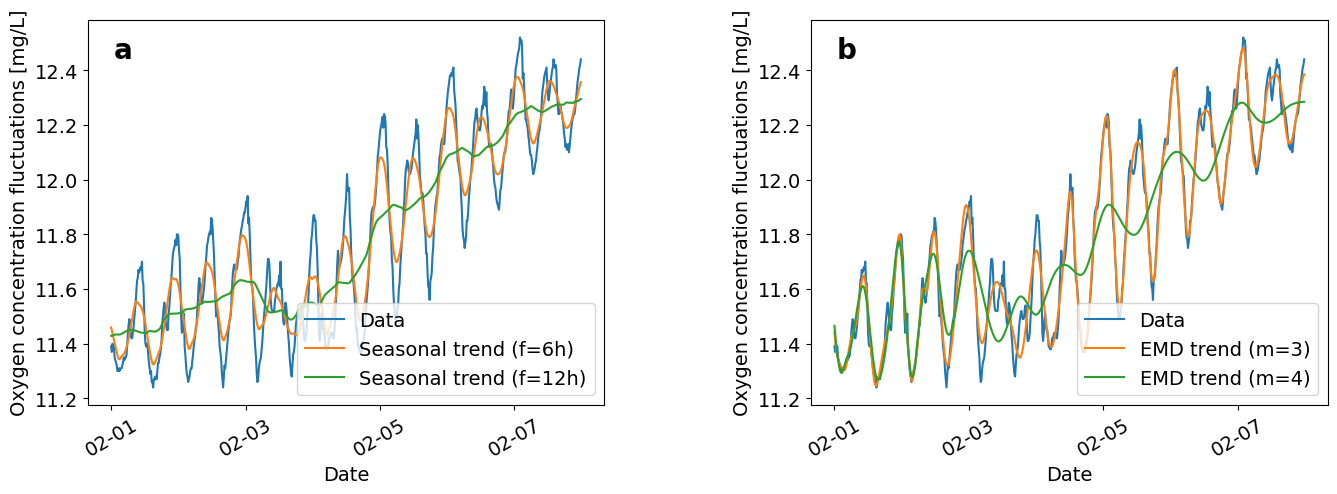

In [49]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=6000
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['Data','Seasonal trend (f=6h)','Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['Data','EMD trend (m=3)','EMD trend (m=4)'], loc=4)
ax1.text(0.05, 0.9, string.ascii_lowercase[0], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.05, 0.9, string.ascii_lowercase[1], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30) 
    axs.set_ylabel(xlabel)
    axs.set_xlabel('Date')
fig.subplots_adjust(wspace =0.4)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show()

In [830]:
#read the data
stationName = 'TKB'

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.6975347818114295, 6375.83385983686, 1.1304593209837752, 1.601667692608646, 1.6667580371984466e-25)
q_likelihood: 6.127


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
E:\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:2042: RuntimeWarning: invalid value encountered in log
  return log(p)


Parameters: (1.5302386068208307, 6679.761293837619, 1.343030600428719, -0.46427746451488194, 1.0911368699724018)
q_likelihood: 7.173


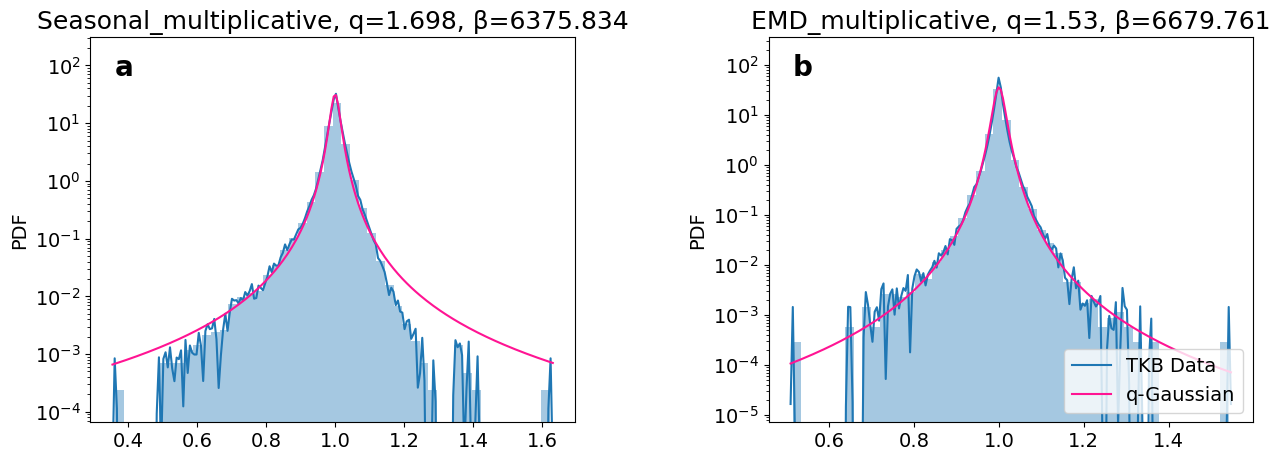

In [29]:
#read the data
stationName = 'TKB'
#set up subplots emd 3
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,0,1.01,6500)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,1,1.1,4000)
f.subplots_adjust(wspace =0.4,hspace=0.4)
#plt.savefig('Figs/'+stationName+'_Fitting.pdf', bbox_inches='tight')
plt.show()

## TPur


In [772]:
#DOO
hour=4
stationName = 'TPur'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=4
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=5 
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [773]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")

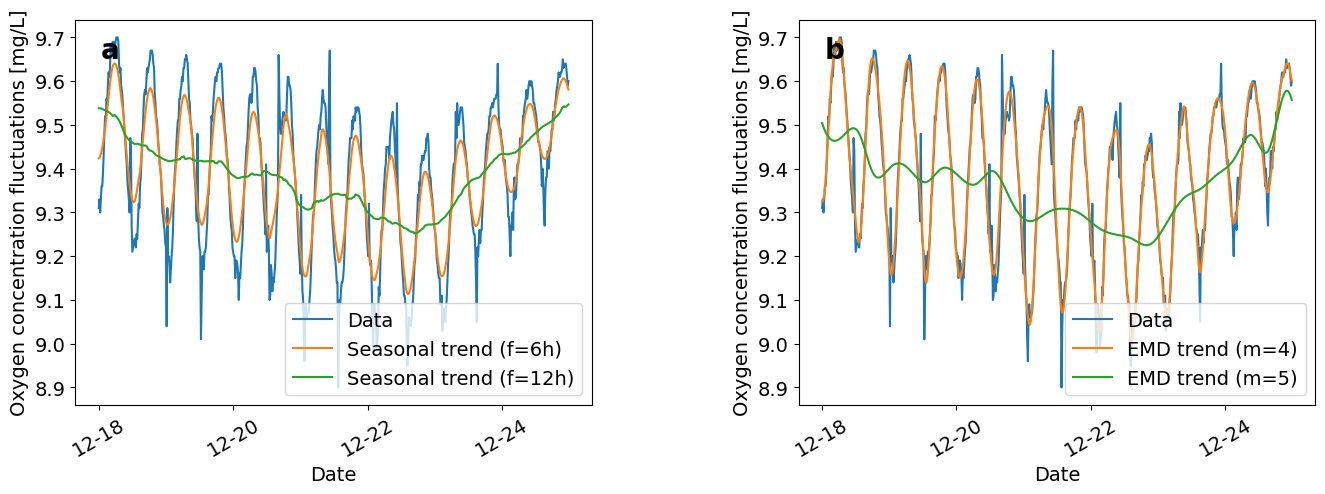

In [144]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=2000-2*24*7
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['Data','Seasonal trend (f=6h)','Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['Data','EMD trend (m=4)','EMD trend (m=5)'], loc=4)
ax1.text(0.05, 0.9, string.ascii_lowercase[0], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.05, 0.9, string.ascii_lowercase[1], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30) 
    axs.set_ylabel(xlabel)
    axs.set_xlabel('Date')
fig.subplots_adjust(wspace =0.4)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show()

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.5149502974408298, 10950.431206741854, 1.3256473216997087, 1.526185643568377, 1.0683847356413803e-27)
q_likelihood: 0.184


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.7480195739701887, 18250.718677903045, 1.3256588794931372, 1.526185643568377, 1.0683847356413803e-27)
q_likelihood: 6.215


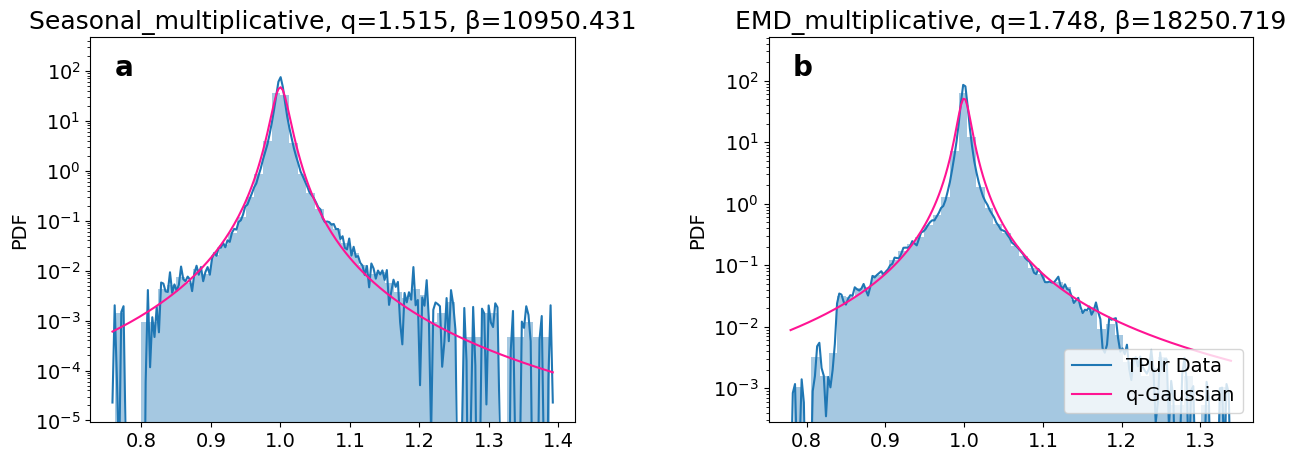

In [30]:
#read the data
stationName = 'TPur'
#set up subplots #EMD 4
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,0,1.3,9000)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,1,1.5,15000)
f.subplots_adjust(wspace =0.4,hspace=0.4)
##plt.savefig('Figs/'+stationName+'_Fitting.pdf', bbox_inches='tight')
plt.show()

## TPut

In [797]:
#DOO
hour=4
stationName = 'TPut'
quantity='DOO-MGL' 
stationData=eval(str(stationName)+'_data')[[quantity,'DATE TIME']].dropna()
stationData=stationData[stationData[quantity]>0]
dates=stationData['DATE TIME']
stationData=np.array(stationData[quantity])

method='Seasonal' 
detrendingParameter=6*hour 
fluctuations_Seasonal_DOO, trend_Seasonal_DOO = detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=12*hour 
fluctuations_Seasonal_DOO2, trend_Seasonal_DOO2 = detrending(stationName, quantity, method, detrendingParameter)

method='EMD'
detrendingParameter=3
fluctuations_EMD_DOO,trend_EMD_DOO=detrending(stationName, quantity, method, detrendingParameter)
detrendingParameter=4 
fluctuations_EMD_DOO2,trend_EMD_DOO2=detrending(stationName, quantity, method, detrendingParameter)

In [798]:
#save dataframes as csv
np.savetxt('DetrendedData/'+stationName+'DOO-MGLSeasonal.csv', fluctuations_Seasonal_DOO, delimiter=",")
np.savetxt('DetrendedData/'+stationName+'DOO-MGLEMD.csv', fluctuations_EMD_DOO, delimiter=",")


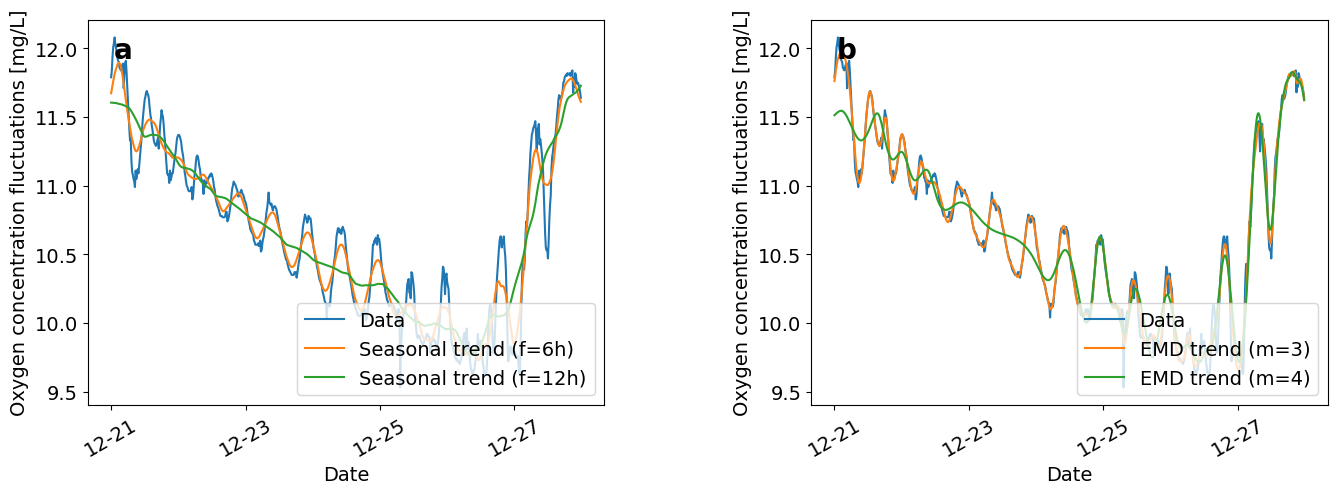

In [43]:
plt.rc('font', size=14)
(xlabel,exportName)=quantityLabels(quantity)
offSet=2000
length=hour*24*7
appliedDates=dates.tolist()[offSet:offSet+length]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(appliedDates,stationData[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO[offSet:offSet+length])
ax1.plot(appliedDates,trend_Seasonal_DOO2[offSet:offSet+length])
ax1.legend(['Data','Seasonal trend (f=6h)','Seasonal trend (f=12h)'], loc=4)
ax2.plot(appliedDates,stationData[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO[offSet:offSet+length])
ax2.plot(appliedDates,trend_EMD_DOO2[offSet:offSet+length])
ax2.legend(['Data','EMD trend (m=3)','EMD trend (m=4)'], loc=4)
ax1.text(0.05, 0.9, string.ascii_lowercase[0], transform=ax1.transAxes,size=20, weight='bold')
ax2.text(0.05, 0.9, string.ascii_lowercase[1], transform=ax2.transAxes,size=20, weight='bold')
for axs in (ax1, ax2):
    axs.set_xticks([appliedDates[0],appliedDates[2*24*4],appliedDates[4*24*4],appliedDates[6*24*4]])
    axs.set_xticklabels([appliedDates[0][5:10],appliedDates[2*24*4][5:10],appliedDates[4*24*4][5:10],appliedDates[6*24*4][5:10]])
    axs.tick_params(axis='x', labelrotation=30) 
    axs.set_ylabel(xlabel)
    axs.set_xlabel('Date')
fig.subplots_adjust(wspace =0.4)
##plt.savefig('Detrend.pdf', bbox_inches='tight')
plt.show()

E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.5149502974408298, 3650.1437355806047, 1.3251402699512496, 1.526185643568377, 1.0683847356413803e-27)
q_likelihood: 2.977


E:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Parameters: (1.6314849357055257, 12167.145785268636, 1.3259883462497615, 1.526185643568377, 1.0683847356413803e-27)
q_likelihood: 6.842


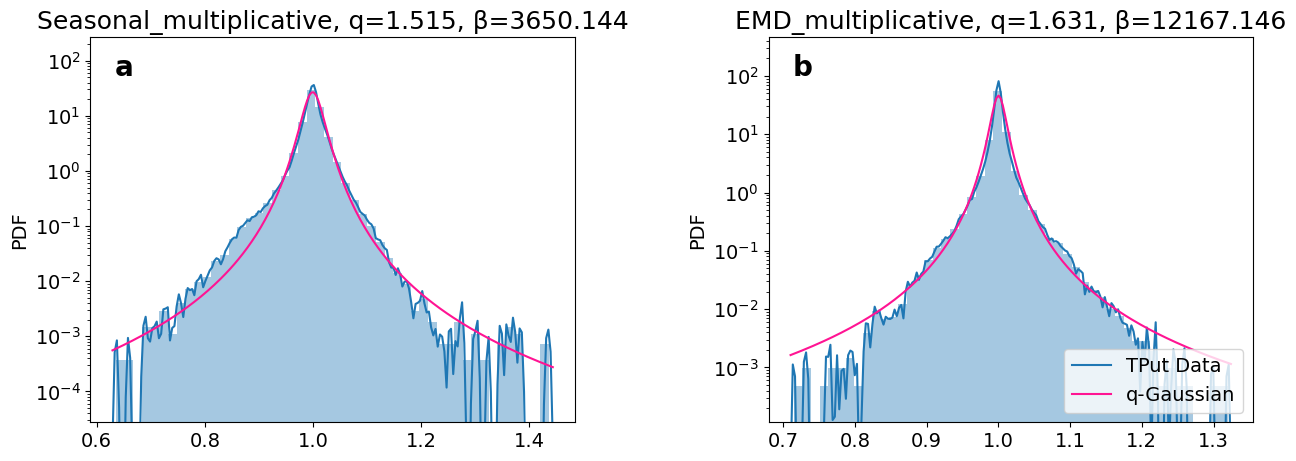

In [31]:
#read the data
stationName = 'TPut'
#set up subplots EMD 3
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
plot_fluctuation_histo_axs('DOO-MGL','Seasonal',stationName,ax1,0,1.3,3000)
plot_fluctuation_histo_axs('DOO-MGL','EMD',stationName,ax2,1,1.4,10000)
f.subplots_adjust(wspace =0.4,hspace=0.4)
#plt.savefig('Figs/'+stationName+'_Fitting.pdf', bbox_inches='tight')
plt.show()